# Praca domowa 3
## Maciej Gryszkiewicz

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import category_encoders as ce
import random
import warnings
warnings.filterwarnings("ignore")
random.seed(42)

In [2]:
df = pd.read_csv("australia.csv")
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [3]:
X = df.drop("RainTomorrow", axis=1)
y = df[["RainTomorrow"]]

## Podział danych na zbiór testowy i treningowy

Do podziału wykorzystam domyślną wielkość parametru test_size, a więc zbiór testowy będzie składał się z 25% obserwacji.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Wybór modelu

Do oceny jakości modelu wykorzystamy 3 metryki:
* accuracy
* precision
* AUC
P

### Model 1 - Regresja Logistyczna

#### Import i uczenie modelu

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2")
lr.fit(X_train, y_train);

Parametr penalty określa normę, która jest wykorzystywana do tworzenia funkcji kary. Funkcja kary jest minimalizowana w procesie uczenia. W tym wypadku używamy regularyzacji klasy 'L2', ponieważ z reguły daje lepsze wyniki.

#### Ocena wydajności

In [6]:
from sklearn.metrics import confusion_matrix

print(pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test)), 
                   columns=["Predicted NO", "Predicted YES"], 
                   index=["Actual NO", "Actual YES"]))

            Predicted NO  Predicted YES
Actual NO          10418            561
Actual YES          1519           1607


Po macierzy pomyłek widzimy że dane są bardzo niezrównoważone. Dni w których nie padało jest zdecydowanie więcej niż dni deszczowych. Przez to, miara Accuracy nie będzie dobrze odzwierciedlała skuteczności modelu. \
\
Dobrą miarą z kolei wydaję się Precision, które powie nam jaka jest szansa, że faktycznie będzie padać jeśli nasz model wskazał deszcz. \
Dla przykładu: Precision na poziomie 75% oznacza, że jeśli nasz model przewiduje dzień deszczowy, to na 75% faktycznie będzie padać.\
\
Bardzo rozsądną miarą w tym wypadku jest również Recall. Miara ta mówi ile deszczowych dni udało nam się przewidzieć ze wszystkich dni w których padało. \
Dla przykładu: Recall na poziomie 50% będzie oznaczał, że udało nam się ostrzec ludzi przed połową wszystkich opadów.

In [7]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(lr, X, y, scoring='accuracy', cv = 10)

print("Accuracy mean: {accuracy}%".format(accuracy=(np.mean(accuracy)*100).round(2)))
print("Accuracy std: {std}pp".format(std=(np.std(accuracy)*100).round(2)))

Accuracy mean: 84.84%
Accuracy std: 1.35pp


In [8]:
precision = cross_val_score(lr, X, y, scoring='precision', cv = 10)

print("Precision mean: {precision}%".format(precision=(np.mean(precision)*100).round(2)))
print("Precision std: {std}pp".format(std=(np.std(precision)*100).round(2)))

Precision mean: 72.22%
Precision std: 6.53pp


In [9]:
recall = cross_val_score(lr, X, y, scoring='recall', cv = 10)

print("Recall mean: {recall}%".format(recall=(np.mean(recall)*100).round(2)))
print("Recall std: {std}pp".format(std=(np.std(recall)*100).round(2)))

Recall mean: 51.77%
Recall std: 5.21pp


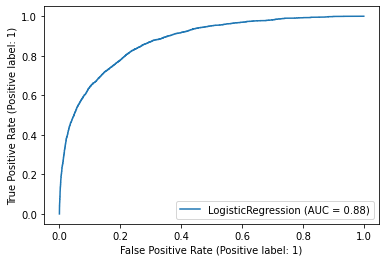

In [10]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

plot_roc_curve(lr, X_test, y_test);

In [11]:
auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print("Exact AUC: {auc}".format(auc=auc))

Exact AUC: 0.8770187801675938


### Model 2 - Decision Tree

#### Import i uczenie modelu

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=6)
dtc.fit(X_train, y_train);

Parametr max_depth określa maksymalną głębokość drzewa, a więc maksymalną ilość podziałów obserwacji na mniejsze podgrupy. Jest to bardzo istotny parametr tego klasyfikatora, w wypadku gdy go nie podamy może dojść do overfittingu, ale również underfittingu. Co ciekawe w tym przypadku, nie podając parametru max_depth tworzy nam się drzewo decyzyjne tylko z jednym węzłem. Jest to spowodowane dużą dysproprocją danych (dużo dni słonecznych, mało deszczowych).

#### Ocena wydajności

In [13]:
print(pd.DataFrame(confusion_matrix(y_test, dtc.predict(X_test)), 
                   columns=["Predicted NO", "Predicted YES"], 
                   index=["Actual NO", "Actual YES"]))

            Predicted NO  Predicted YES
Actual NO          10383            596
Actual YES          1556           1570


In [14]:
accuracy = cross_val_score(dtc, X, y, scoring='accuracy', cv = 10)

print("Accuracy mean: {accuracy}%".format(accuracy=(np.mean(accuracy)*100).round(2)))
print("Accuracy std: {std}pp".format(std=(np.std(accuracy)*100).round(2)))

Accuracy mean: 84.3%
Accuracy std: 1.45pp


In [15]:
precision = cross_val_score(dtc, X, y, scoring='precision', cv = 10)

print("Precision mean: {precision}%".format(precision=(np.mean(precision)*100).round(2)))
print("Precision std: {std}pp".format(std=(np.std(precision)*100).round(2)))

Precision mean: 71.12%
Precision std: 6.31pp


In [16]:
recall = cross_val_score(dtc, X, y, scoring='recall', cv = 10)

print("Recall mean: {recall}%".format(recall=(np.mean(recall)*100).round(2)))
print("Recall std: {std}pp".format(std=(np.std(recall)*100).round(2)))

Recall mean: 49.17%
Recall std: 5.24pp


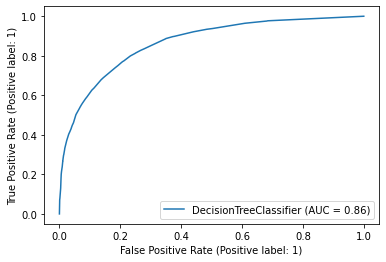

In [17]:
plot_roc_curve(dtc, X_test, y_test);

### Model 3 - XGBoost

#### Import i uczenie modelu

In [18]:
from xgboost import XGBClassifier

xgb = XGBClassifier(learning_rate=0.1, n_estiamtors=1000, max_depth=6, verbosity=0)
xgb.fit(X_train, y_train);

W tym wypadku parametr max_depth działa analogicznie do tego w DecissionTree. \
\
Parametr learning_rate (lub eta) jest charakterystyczny dla metod boostingowych. Czym wyższa jego wartość, tym model szybciej się uczy, ale jest mniej dopasowany do danych. Wartość ta zmniejsza wagę obserwacji źle zaklasyfikowanych z każdą iteracją boostingową. Zbyt niska wartość tego parametru prowadzi do overfittingu.\
\
Parametr n_estimators oznacza ilość drzew, która zostanie stworzona w procesie boostingu. Np. gdyby ten parametr był równy 1 to model wynikowy byłby zwykłym DecisionTree.\
\
Parametr verbosity=0 zapobiega wyświetlaniu wiadomości (np. warningów)  przy tworzeniu modelu.

#### Ocena wydajności

In [19]:
print(pd.DataFrame(confusion_matrix(y_test, xgb.predict(X_test)), 
                   columns=["Predicted NO", "Predicted YES"], 
                   index=["Actual NO", "Actual YES"]))

            Predicted NO  Predicted YES
Actual NO          10438            541
Actual YES          1430           1696


In [20]:
accuracy = cross_val_score(xgb, X, y, scoring='accuracy', cv = 10)

print("Accuracy mean: {accuracy}%".format(accuracy=(np.mean(accuracy)*100).round(2)))
print("Accuracy std: {std}pp".format(std=(np.std(accuracy)*100).round(2)))

Accuracy mean: 85.12%
Accuracy std: 1.54pp


In [21]:
precision = cross_val_score(xgb, X, y, scoring='precision', cv = 10)

print("Precision mean: {precision}%".format(precision=(np.mean(precision)*100).round(2)))
print("Precision std: {std}pp".format(std=(np.std(precision)*100).round(2)))

Precision mean: 72.84%
Precision std: 5.82pp


In [22]:
recall = cross_val_score(xgb, X, y, scoring='recall', cv = 10)

print("Recall mean: {recall}%".format(recall=(np.mean(recall)*100).round(2)))
print("Recall std: {std}pp".format(std=(np.std(recall)*100).round(2)))

Recall mean: 52.09%
Recall std: 5.59pp


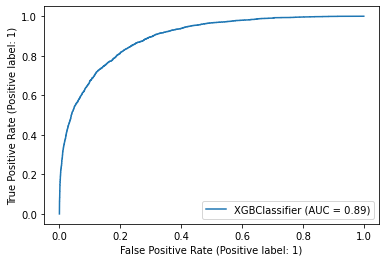

In [23]:
plot_roc_curve(xgb, X_test, y_test);

In [24]:
auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])
print("Exact AUC: {auc}".format(auc=auc))

Exact AUC: 0.8934907839237323


### Podsumowanie

XGBoost Classifier miał najwyższe miary każdej z metryk, jednoznacznie jest on najlepszym modelem w tym wypadku. Co najważniejsze, miał on najwyższy współczynnik Recall, a więc to dzięki niemu uchronimy najwięcej ludzi przed zmoknięciem.